Showing off Sequential Neural Likelihood/Likelihoord Ratio method on the example problem from https://arxiv.org/abs/1805.07226 detailed in A.1 with posteriors plotted in Figure 5a. 

SNLR is performing quite well. Still need to figure out why SNL isn't working as well

In [1]:
import numpy as np
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import corner

%load_ext autoreload
%autoreload 2

In [2]:
# remove top and right axis from plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [3]:
import pyro
from pyro.distributions import Beta, Binomial, HalfCauchy, Normal, Pareto, Uniform
from pyro.distributions.util import scalar_like
from pyro.infer import MCMC, NUTS, Predictive
from pyro.infer.mcmc.util import initialize_model, summary
from pyro.util import ignore_experimental_warning

In [4]:
import lbi.models
from lbi.nde import NeuralRatioEstimator, NeuralLikelihoodEstimator
from lbi.sequential import Sequential

In [5]:
def simulator(parameter_set, **kwargs):
    obs_dim = 8
    
    m_theta = parameter_set[:, :2]
    s1 = parameter_set[:, 2].pow(2)    
    s2 = parameter_set[:, 3].pow(2)
    rho = torch.tanh(parameter_set[:, 4])
    S_theta = [torch.stack([s1.pow(2), rho*s1*s2], dim=-1), 
               torch.stack([rho*s1*s2, s2.pow(2)], dim=-1)]
    S_theta = torch.stack(S_theta, dim=-1)

    # TODO: Speed this up
    samples = []
    for m_th, S_th in zip(m_theta, S_theta):
        dist = torch.distributions.MultivariateNormal(m_th, S_th)
        sample = dist.sample((obs_dim//2,)).flatten()
        samples.append(sample)

    return torch.stack(samples)

In [6]:
param_dim = 5
obs_dim = 8
true_param = torch.tensor([[0.7, -2.9, -1., -0.9, 0.6]])
observation = simulator(true_param)

In [7]:
# Make multivariate uniform prior distribution
priors = torch.distributions.Independent(torch.distributions.Uniform(low=-3*torch.ones(param_dim), high=3*torch.ones(param_dim)), 
                                         reinterpreted_batch_ndims=1)

In [8]:
layers = [['Linear', obs_dim + param_dim, 64], ['SELU'], 
          ['Linear', 64, 64], ['SELU'], 
          ['Linear', 64, 1]]
model = lbi.models.Classifier(layers=layers)
optimizer = torch.optim.AdamW(model.parameters())
nre = NeuralRatioEstimator(model)

In [9]:
snre = Sequential(priors=priors, obs_data=observation, param_dim=param_dim, model=nre, optimizer=optimizer, 
                  simulator=simulator, 
                  n_rounds=10,
                  sims_per_model=1,
                  num_initial_samples=500,
                  num_samples_per_round=1000)

In [10]:
snre.run()

Training on 425 samples. Validating on 75 samples.


Warmup:   7%|▋         | 21/300 [00:00, 209.57it/s, step size=3.23e-01, acc. prob=0.734]

Round 1 complete. Time elapsed: 0m 1s. Total time elapsed: 0m 1s.


Sample: 100%|██████████| 300/300 [00:02, 128.67it/s, step size=7.24e-02, acc. prob=0.850]


Training on 1,275 samples. Validating on 225 samples.


Warmup:   3%|▎         | 9/300 [00:00, 59.72it/s, step size=3.82e-02, acc. prob=0.628]

Round 2 complete. Time elapsed: 0m 5s. Total time elapsed: 0m 6s.


Sample: 100%|██████████| 300/300 [00:01, 196.98it/s, step size=4.42e-01, acc. prob=0.582]


Training on 2,125 samples. Validating on 375 samples.


Warmup:   7%|▋         | 22/300 [00:00, 208.31it/s, step size=5.24e-02, acc. prob=0.708]

Round 3 complete. Time elapsed: 0m 7s. Total time elapsed: 0m 12s.


Sample: 100%|██████████| 300/300 [00:03, 77.07it/s, step size=2.48e-02, acc. prob=0.912] 


Training on 2,975 samples. Validating on 525 samples.


Warmup:   6%|▋         | 19/300 [00:00, 177.83it/s, step size=6.15e-02, acc. prob=0.723]

Round 4 complete. Time elapsed: 0m 10s. Total time elapsed: 0m 23s.


Sample: 100%|██████████| 300/300 [00:02, 133.26it/s, step size=7.74e-02, acc. prob=0.854]


Training on 3,825 samples. Validating on 675 samples.


Warmup:   2%|▏         | 6/300 [00:00, 56.25it/s, step size=3.44e-02, acc. prob=0.567]

Round 5 complete. Time elapsed: 0m 11s. Total time elapsed: 0m 33s.


Sample: 100%|██████████| 300/300 [00:02, 100.91it/s, step size=1.12e-01, acc. prob=0.857]


Training on 4,675 samples. Validating on 825 samples.


Warmup:   3%|▎         | 8/300 [00:00, 77.17it/s, step size=6.60e-02, acc. prob=0.655]

Round 6 complete. Time elapsed: 0m 14s. Total time elapsed: 0m 47s.


Sample: 100%|██████████| 300/300 [00:02, 147.69it/s, step size=1.11e-01, acc. prob=0.774]


Training on 5,525 samples. Validating on 975 samples.


Warmup:   2%|▏         | 5/300 [00:00, 25.22it/s, step size=3.12e-03, acc. prob=0.398]

Round 7 complete. Time elapsed: 0m 15s. Total time elapsed: 1m 2s.


Sample: 100%|██████████| 300/300 [00:02, 144.84it/s, step size=2.21e-01, acc. prob=0.756]


Training on 6,375 samples. Validating on 1,125 samples.


Warmup:   4%|▍         | 12/300 [00:00, 93.50it/s, step size=6.00e-02, acc. prob=0.701]

Round 8 complete. Time elapsed: 0m 20s. Total time elapsed: 1m 22s.


Sample: 100%|██████████| 300/300 [00:05, 57.61it/s, step size=2.67e-02, acc. prob=0.932] 


Training on 7,225 samples. Validating on 1,275 samples.


Warmup:   5%|▍         | 14/300 [00:00, 138.91it/s, step size=4.73e-02, acc. prob=0.693]

Round 9 complete. Time elapsed: 0m 22s. Total time elapsed: 1m 44s.


Sample: 100%|██████████| 300/300 [00:01, 180.39it/s, step size=2.23e-01, acc. prob=0.658]


Training on 8,075 samples. Validating on 1,425 samples.
Early stopped after 199 epochs
Round 10 complete. Time elapsed: 0m 21s. Total time elapsed: 2m 4s.


In [20]:
posterior_samples = snre.hmc(num_samples=200000, walker_steps=7500, burn_in=500)

Sample: 100%|██████████| 8000/8000 [00:46, 171.40it/s, step size=1.20e-01, acc. prob=0.758]


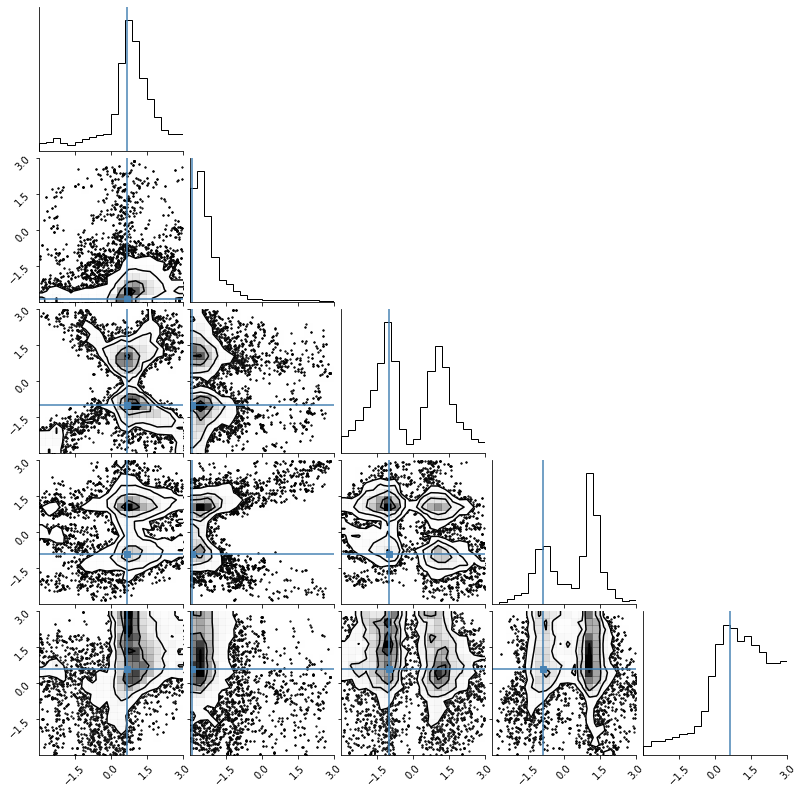

In [21]:
corner.corner(posterior_samples.numpy(), 
              range=[(-3, 3) for i in range(param_dim)], 
              truths=true_param[0].numpy());

In [22]:
model = lbi.models.ConditionalFlow(dim=obs_dim, 
                                   context_dim=param_dim, 
                                   transform_type='autoregressive', 
                                   n_layers=1, 
                                   hidden_units=128,
                                   n_blocks=2, 
                                   dropout=0., 
                                   use_batch_norm=False, 
                                   tails='linear', 
                                   tail_bound=5, 
                                   n_bins=10,
                                   min_bin_height=1e-5, 
                                   min_bin_width=1e-5, 
                                   min_derivative=1e-5, 
                                   unconditional_transform=True,
                                   encoder=None)
optimizer = torch.optim.Adam(model.parameters())
nle = NeuralLikelihoodEstimator(model)

In [23]:
snle = Sequential(priors=priors, obs_data=observation, param_dim=param_dim, model=nle, optimizer=optimizer, 
                  simulator=simulator, 
                  reset_every_round=True,
                  n_rounds=10,
                  sims_per_model=1,
                  max_n_epochs=200,
                  num_initial_samples=1000,
                  num_samples_per_round=1000)

In [24]:
snle.run()

Training on 850 samples. Validating on 150 samples.


Warmup:   0%|          | 0/300 [00:00, ?it/s]

Round 1 complete. Time elapsed: 0m 5s. Total time elapsed: 0m 5s.


Sample: 100%|██████████| 300/300 [00:20, 14.87it/s, step size=3.96e-02, acc. prob=0.853]


Training on 1,700 samples. Validating on 300 samples.


Warmup:   2%|▏         | 5/300 [00:00, 33.31it/s, step size=1.73e-02, acc. prob=0.467]

Round 2 complete. Time elapsed: 0m 30s. Total time elapsed: 0m 36s.


Sample: 100%|██████████| 300/300 [00:07, 39.13it/s, step size=2.96e-01, acc. prob=0.734]


Training on 2,550 samples. Validating on 450 samples.


Warmup:   1%|          | 3/300 [00:00, 15.63it/s, step size=4.23e-04, acc. prob=0.147]

Round 3 complete. Time elapsed: 0m 23s. Total time elapsed: 0m 59s.


Sample: 100%|██████████| 300/300 [01:28,  3.40it/s, step size=1.30e-01, acc. prob=0.756]


Training on 3,400 samples. Validating on 600 samples.


Warmup:   1%|▏         | 4/300 [00:00, 24.43it/s, step size=4.06e-02, acc. prob=0.561]

Round 4 complete. Time elapsed: 1m 53s. Total time elapsed: 2m 52s.


Sample: 100%|██████████| 300/300 [00:20, 14.87it/s, step size=7.70e-02, acc. prob=0.904]


Training on 4,250 samples. Validating on 750 samples.


Warmup:   2%|▏         | 5/300 [00:00, 39.86it/s, step size=4.19e-02, acc. prob=0.526]

Round 5 complete. Time elapsed: 0m 49s. Total time elapsed: 3m 41s.


Sample: 100%|██████████| 300/300 [00:09, 31.83it/s, step size=1.06e-01, acc. prob=0.824]


Training on 5,100 samples. Validating on 900 samples.


Warmup:   2%|▏         | 5/300 [00:00, 36.61it/s, step size=6.49e-03, acc. prob=0.494]

Round 6 complete. Time elapsed: 0m 43s. Total time elapsed: 4m 24s.


Sample: 100%|██████████| 300/300 [01:22,  3.63it/s, step size=6.00e-03, acc. prob=0.951]


Training on 5,950 samples. Validating on 1,050 samples.


Warmup:   2%|▏         | 6/300 [00:00, 47.43it/s, step size=1.72e-03, acc. prob=0.479]

Round 7 complete. Time elapsed: 2m 4s. Total time elapsed: 6m 28s.


Sample: 100%|██████████| 300/300 [00:50,  5.99it/s, step size=2.43e-02, acc. prob=0.866]


Training on 6,800 samples. Validating on 1,200 samples.


Warmup:   3%|▎         | 8/300 [00:00, 60.74it/s, step size=5.65e-02, acc. prob=0.677]

Round 8 complete. Time elapsed: 1m 36s. Total time elapsed: 8m 5s.


Sample: 100%|██████████| 300/300 [00:16, 18.48it/s, step size=8.72e-02, acc. prob=0.874]


Training on 7,650 samples. Validating on 1,350 samples.


Warmup:   2%|▏         | 7/300 [00:00, 57.94it/s, step size=2.79e-02, acc. prob=0.657]

Round 9 complete. Time elapsed: 1m 9s. Total time elapsed: 9m 14s.


Sample: 100%|██████████| 300/300 [00:18, 15.81it/s, step size=1.55e-02, acc. prob=0.810]


Training on 8,500 samples. Validating on 1,500 samples.
Early stopped after 180 epochs
Round 10 complete. Time elapsed: 1m 13s. Total time elapsed: 10m 27s.


In [ ]:
posterior_samples = snle.hmc(num_samples=200000, walker_steps=2500, burn_in=500)

Warmup:   3%|▎         | 93/3000 [00:21,  6.48it/s, step size=3.82e-03, acc. prob=0.767]

In [ ]:
corner.corner(posterior_samples.numpy(), 
              range=[(-3, 3) for i in range(param_dim)], 
              truths=true_param[0].numpy());